In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams.update({'font.size': 10})

In [2]:
test_file = 'mlearning/test.csv'
train_file = 'mlearning/train.csv'
sample_file = 'mlearning/sample_submission.csv'

In [3]:
test = pd.read_csv(test_file)
train = pd.read_csv(train_file)
sample = pd.read_csv(sample_file)

In [4]:
def replace_value(col1, col2):
    
    list_id = pd.Series(train.loc[train[col1] < train[col2], 'Id'].copy())
    a = list(train.loc[train[col1] < train[col2], col1]).copy()
    b = list(train.loc[train[col1] < train[col2], col2]).copy()
    train.loc[train['Id'].isin(list_id), col1] = b
    train.loc[train['Id'].isin(list_id), col2] = a

## Просмотр данных

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [5]:
train = train.merge(test, how='outer')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Helthcare_2    15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_

In [7]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,15000.0,8393.136933,4850.111673,0.000000,4188.750000,8378.500000,12594.250000,1.679800e+04
DistrictId,15000.0,50.693600,43.786257,0.000000,20.000000,37.000000,75.000000,2.120000e+02
Rooms,15000.0,1.897000,0.839229,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,15000.0,56.360350,20.423913,1.136859,41.814371,52.645757,66.036608,6.410652e+02
LifeSquare,11846.0,36.851792,71.120183,0.333490,22.896130,32.822810,45.144624,7.480592e+03
KitchenSquare,15000.0,6.174467,24.016979,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,15000.0,8.561800,5.323113,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,15000.0,12.606600,6.780165,0.000000,9.000000,12.000000,17.000000,1.170000e+02
HouseYear,15000.0,3321.575067,163707.780381,1908.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,15000.0,0.119196,0.119371,0.000000,0.017647,0.075424,0.195781,5.218671e-01


## Изменение типов данных

Количество комнат и этажность дома - это всегда целые числа. А Площадь кухни - не может быть целым числом. Поэтому меняем формат.

In [9]:
train['Rooms'] = train['Rooms'].astype(int)
train['HouseFloor'] = train['HouseFloor'].astype(int)
train['KitchenSquare'] = train['KitchenSquare'].astype(float)
train['Ecology_2'] = (train['Ecology_2'] == 'A').astype(int)
train['Ecology_3'] = (train['Ecology_3'] == 'A').astype(int)
train['Shops_2'] = (train['Shops_2'] == 'A').astype(int)

In [10]:
list_float64 = train.dtypes[train.dtypes=='float64'].index
train[list_float64] = train[list_float64].astype('float32')
list_in64 = train.dtypes[train.dtypes=='int64'].index
train[list_in64] = train[list_in64].astype('int32')

## Заполнение пропусков

Заполняем пропуски в LifeSquare. Пропущено примерно 20% значений. Заполняем данным по общей площади, так медианные значения могут быть больше.

In [11]:
train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] = train['Square']

В Healthcare_1 очень много пропусков - почти 50% значений. Чтобы заполнить более точными данными, решил ориентироваться на второй признак в этой группе - Helthcare_2.

In [12]:
train['Helthcare_2'].unique()

array([0, 1, 2, 5, 3, 6, 4], dtype=int32)

<function matplotlib.pyplot.show(*args, **kw)>

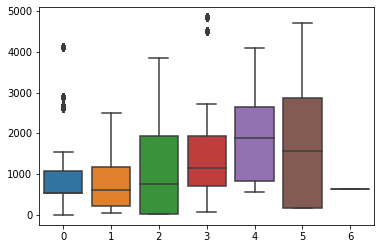

In [13]:
short_train = train.loc[train['Healthcare_1'].notnull()]
hc1_1 = list(short_train['Healthcare_1'])
sc1_1 = list(short_train['Helthcare_2'])
sns.boxplot(sc1_1, hc1_1)
plt.show

И заполнить медиаными значениями для непропущенных значений.

In [14]:
col1 = 'Healthcare_1'
col2 = 'Helthcare_2'

median = train.groupby(col2).median()

for i in range(len(train[col2].unique())):
    train.loc[(train[col1].isnull())&(train[col2] == i), col1] = median.loc[i, col1]
    i = i+1

## Обработка выбросов

Обработка максимальных значений

In [15]:
train.loc[train['HouseYear'] > 2020, 'HouseYear']

1497    20052011
4189        4968
Name: HouseYear, dtype: int32

In [16]:
train.loc[train['HouseYear'] > 2020, 'HouseYear'] = train['HouseYear'].median()

In [17]:
train.loc[train['LifeSquare'] > 1000, ['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
4328,81.69442,7480.592285,1.0


In [18]:
train.loc[train['LifeSquare'] > 1000, 'LifeSquare'] = train['Square']

Изменение выбросов Площади кухни.

In [19]:
train.loc[train['KitchenSquare'] > 10, ['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
5,80.384476,46.683720,12.0
19,110.959793,56.996765,11.0
38,77.873940,48.991135,12.0
48,47.080101,46.807991,12.0
85,54.583233,33.320301,11.0
...,...,...,...
14899,87.358307,48.261597,11.0
14929,52.507713,21.368216,13.0
14960,86.719154,52.019073,11.0
14975,110.366486,77.705849,20.0


In [20]:
train.loc[train['KitchenSquare'] > 10, 'KitchenSquare'] = train['KitchenSquare'].median()

Вряд ли можно встретить десятикомнатную квартиру общей плошадью 40-60 кв метров...

In [21]:
train.loc[train['Rooms'] > 9, ['Rooms', 'Square']]

,Rooms,Square
377,10,59.056976
1454,19,42.006046
8849,10,60.871265
13398,17,52.866108


In [22]:
train.loc[train['Rooms'] > 9, 'Rooms'] = train['Rooms'].median()

Обработка минимальных значений

In [23]:
train.loc[train['Rooms'] == 0, ['Rooms', 'Square']]

,Rooms,Square
1397,0.0,138.427689
1981,0.0,212.932358
2269,0.0,41.790882
3911,0.0,49.483501
4366,0.0,81.491447
4853,0.0,2.377248
6149,0.0,38.697117
8834,0.0,87.762619
12406,0.0,116.824203
12524,0.0,76.345154


In [24]:
train.loc[train['Rooms'] == 0, 'Rooms'] = train['Rooms'].median()

Этажность дома должна быть как минимум 1 этаж, но не ниже этажа недвижимости.

In [25]:
train.loc[train['HouseFloor'] == 0, ['Floor' ,'HouseFloor']]

,Floor,HouseFloor
7,14,0
23,2,0
26,17,0
39,16,0
44,20,0
...,...,...
14856,10,0
14887,20,0
14892,4,0
14976,6,0


In [26]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = train['Floor']

In [27]:
train.loc[train['Square'] < 10, 'Square'] = train['Square'].median()
train.loc[train['LifeSquare'] < 10, 'LifeSquare'] = train['Square']

## Добавление признака "Средняя цена за 1 кв метр в районе"

In [28]:
by_district_median = train.groupby('DistrictId').median()
Med_dis_1sqr_price = by_district_median['Price']/by_district_median['Square']
Med_dis_1sqr_price = pd.DataFrame(Med_dis_1sqr_price)
train = pd.merge(train, Med_dis_1sqr_price, on = 'DistrictId', how = 'right')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,0
0,14038,35,2.0,47.981560,29.442751,6.0,7,9,1969.0,0.08904,...,0,33,7976,5,540.0,0,11,0,184966.937500,4248.527832
1,4698,35,3.0,63.851402,47.245735,6.0,7,9,1971.0,0.08904,...,0,33,7976,5,540.0,0,11,0,242403.718750,4248.527832
2,8610,35,1.0,47.410774,47.410774,0.0,4,4,1977.0,0.08904,...,0,33,7976,5,540.0,0,11,0,218138.093750,4248.527832
3,8401,35,2.0,43.325817,22.487877,6.0,7,14,1969.0,0.08904,...,0,33,7976,5,540.0,0,11,0,194175.390625,4248.527832
4,12932,35,1.0,46.287193,46.287193,1.0,13,12,2015.0,0.08904,...,0,33,7976,5,540.0,0,11,0,195895.984375,4248.527832


Переименуем колонку проверим отсутствие значений в новом признаке, так как ранее объединяли с тестовым файлом, где не было цен.

In [29]:
train.rename(columns={0: 'Med_dis_1sqr_price'}, inplace=True)
train['Med_dis_1sqr_price'].isnull().sum()

8

In [30]:
train.loc[train['Med_dis_1sqr_price'].isnull(), 'Med_dis_1sqr_price'] = train['Med_dis_1sqr_price'].median()

## Проверка несогласованных значений

Очевидно перепутаны значения "Жилая площадь" и "Общая площадь" 

In [31]:
train.loc[train['Square'] < train['LifeSquare'], ['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
189,42.357697,46.520149,5.0
219,55.663734,56.939110,10.0
249,57.536324,57.857822,1.0
255,41.022587,42.942402,1.0
257,38.751591,39.703850,1.0
...,...,...,...
14886,81.557304,81.647377,6.0
14936,38.850311,39.594067,6.0
14952,409.425171,410.639740,10.0
14953,93.438980,95.489517,10.0


In [32]:
replace_value('Square', 'LifeSquare')

Тоже самое "Этаж" и "Этажность дома"

In [33]:
train.loc[train['HouseFloor'] < train['Floor'], ['Floor', 'HouseFloor']]

,Floor,HouseFloor
4,13,12
20,10,9
22,13,12
33,18,17
44,10,9
...,...,...
14987,7,5
14991,9,8
14994,7,6
14996,8,7


In [34]:
replace_value('HouseFloor', 'Floor')

## Категориальные признаки и добавление новых

### 1. Объединение 2х социальных признаков в один.

Выявляем и с помощью PCA объединяем линейно зависимые признаки
Общая и жилая площади

Text(0, 0.5, 'Social 2')

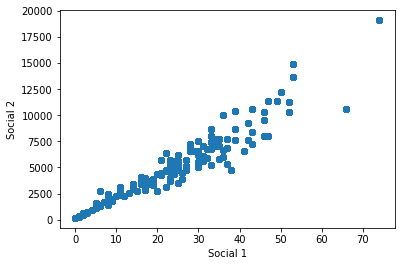

In [35]:
plt.scatter(train['Social_1'], train['Social_2'])
plt.xlabel('Social 1')
plt.ylabel('Social 2')

In [36]:
pca = PCA(n_components=1)
train['Social_pca'] = pca.fit_transform(train[['Social_1', 'Social_2']])
train = train.drop(['Social_1', 'Social_2'], axis=1)

### 2. Признак Big Square (большая площадь)

In [37]:
train['Big_Square'] = 0
train.loc[train['Square'] > 90, 'Big_Square'] = 1

### 3. Категорийные признаки

Переводим один из признаков здравоохранения в категорийный, так как у него только 7 значений

In [38]:
train['Big_Square'] = train['Big_Square'].astype(str)
train['Helthcare_2'] = train['Helthcare_2'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

In [39]:
train = pd.get_dummies(train)

## Распределение целевого признака

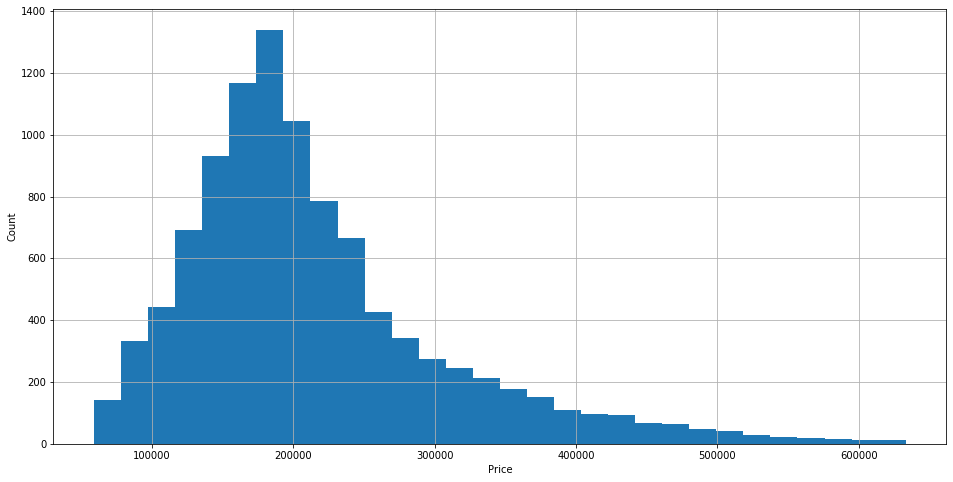

In [40]:
plt.figure(figsize = (16, 8))

train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.show()

## Разбиение на сеты

Сначала устанавливаем ID в качестве индекса.

In [41]:
train = train.set_index('Id')

Обратно разбиваем тренировочный и тестовый сеты

In [42]:
train_new = train.loc[train['Price'].notnull()]
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 4660
Columns: 238 entries, Rooms to Big_Square_1
dtypes: float32(7), float64(5), int32(5), uint8(221)
memory usage: 3.0 MB


In [43]:
test_new = train.loc[train['Price'].isnull()]
test_new = test_new.drop('Price', axis=1)
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 4247 to 14024
Columns: 237 entries, Rooms to Big_Square_1
dtypes: float32(6), float64(5), int32(5), uint8(221)
memory usage: 1.5 MB


Целевой признак - Цена на недвижимость

In [44]:
y = pd.Series(train_new['Price'])
y

Id
14038    184966.937500
4698     242403.718750
8610     218138.093750
8401     194175.390625
12932    195895.984375
             ...      
15391    324303.812500
16543    220501.562500
11911    140048.796875
15968    170893.640625
4660      87268.101562
Name: Price, Length: 10000, dtype: float32

Тренировочный и тестовые данные

In [45]:
X = train_new.drop('Price', axis=1)

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=100)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7000, 237), (3000, 237), (7000,), (3000,))

## Построение модели

In [47]:
random_forest = RandomForestRegressor(random_state=100,
                                      max_depth=None,
                                      max_features=50,
                                      min_samples_leaf=2,
                                      n_estimators=900)

In [48]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=50, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=900, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [49]:
y_pred = random_forest.predict(X_valid)

In [50]:
r2_score(y_valid, y_pred)

0.7538157037953683

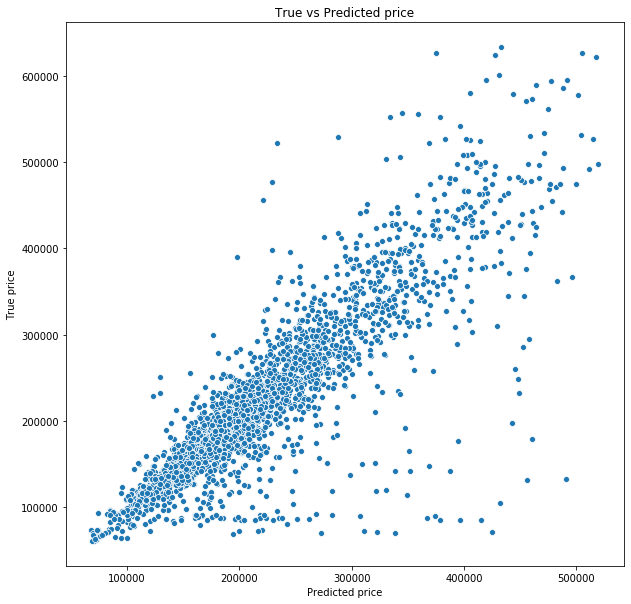

In [51]:
plt.figure(figsize=(10,10))
sns.scatterplot(y_pred, y_valid)
plt.xlabel('Predicted price')
plt.ylabel('True price')
plt.title('True vs Predicted price')
plt.show()

In [52]:
cv_score = cross_val_score(random_forest, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=100))
cv_score

array([0.7454155 , 0.76971862, 0.74680502, 0.77583328, 0.76420171])

In [53]:
cv_score.mean()

0.7603948252268022

In [54]:
feature_importances = pd.DataFrame(zip(X_train.columns, random_forest.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False).head(15)

,feature_name,importance
1,Square,0.234209
14,Med_dis_1sqr_price,0.174698
0,Rooms,0.116061
2,LifeSquare,0.084417
15,Social_pca,0.061029
10,Social_3,0.042523
6,HouseYear,0.034574
5,HouseFloor,0.026926
3,KitchenSquare,0.026169
12,Shops_1,0.025197


## Прогноз для test.csv

In [55]:
X_train = X
X_test = test_new
y_train = y

In [56]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=50, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=900, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [57]:
y_pred_test = random_forest.predict(X_test)
y_pred_test

array([175617.69241651, 251666.42890413, 193970.47450666, ...,
       208925.60542717, 208792.55343551, 180310.2921171 ])

In [58]:
test_new['Price'] = y_pred_test

In [66]:
test_price = test_new
NVPotseluev_predictions = pd.DataFrame(test_price['Price'])

In [67]:
NVPotseluev_predictions

,Price
Id,
4247,175617.692417
15023,251666.428904
4974,193970.474507
4023,256602.885656
6427,165721.127416
...,...
13382,216066.883205
9155,388718.717848
8845,208925.605427


In [68]:
NVPotseluev_predictions.to_csv('NVPotseluev_predictions.csv', sep=",")